### 对抗生成网络

#### ***GAN*** 网络流程图
<img src="./assets/GAN过程示意图.png" style="margin-left: 0px" width=500px>

***目标*** ：让生成器（Generator）从100维随机噪声生成逼真的数字"2"（28×28×1灰度图），并欺骗判别器（Discriminator）将其判定为真实图像（输出概率越接近1，说明生成质量越高）。

#### ***辨别器*** 的两种输入
<img src="./assets/辨别器的两种输入.png" style="margin-left: 0px" width=500px>


***目标*** ：准确区分真实图像与生成图像：对于输入图像，输出一个0~1的判别概率值，其中接近1表示判定为真实数据（如真实手写数字），接近0则表示判定为生成数据（如生成器合成的图像）

***简单来说***

***判别器*** 像 ***验钞机*** ，给它一张图，它输出一个0~1的数：
1. 接近1 → "真的！"（比如真实手写数字）
2. 接近0 → "假的！"（比如生成器造的图）

***生成器*** 像 ***造假币*** 的：
拼命改进假币质量，想让验钞机输出"1"（以为是真的）

***两者互相斗*** ：
验钞机升级→生成器跟着升级→直到假币逼真到验钞机分不清（输出0.5）

***目标函数（损失函数）*** 定义：一方面要让判别器分辨能力更强，另一方面要让生成器更真

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

%matplotlib inline

In [2]:
noise_dim = 100 # 向量的维度
img_shape = 784  # 28x28
batch_size = 64
epochs = 100
learning_rate = 1e-4

#### ***加载数据***

In [3]:
# 数据集下载地址：https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz

# 指定本地路径
path = './mnist.npz'
with np.load(path, allow_pickle=True) as f:
    train_images, train_labels = f['x_train'], f['y_train']
    test_images, test_labels = f['x_test'], f['y_test']

# 归一化
train_images = train_images / 255.0

In [4]:
train_samples = train_images.shape[0]  # 训练集图片数
test_samples = test_images.shape[0]    # 测试集图片数
print(f"训练集图片数: {train_samples}")  # 输出: 60000
print(f"测试集图片数: {test_samples}")    # 输出: 10000

训练集图片数: 60000
测试集图片数: 10000


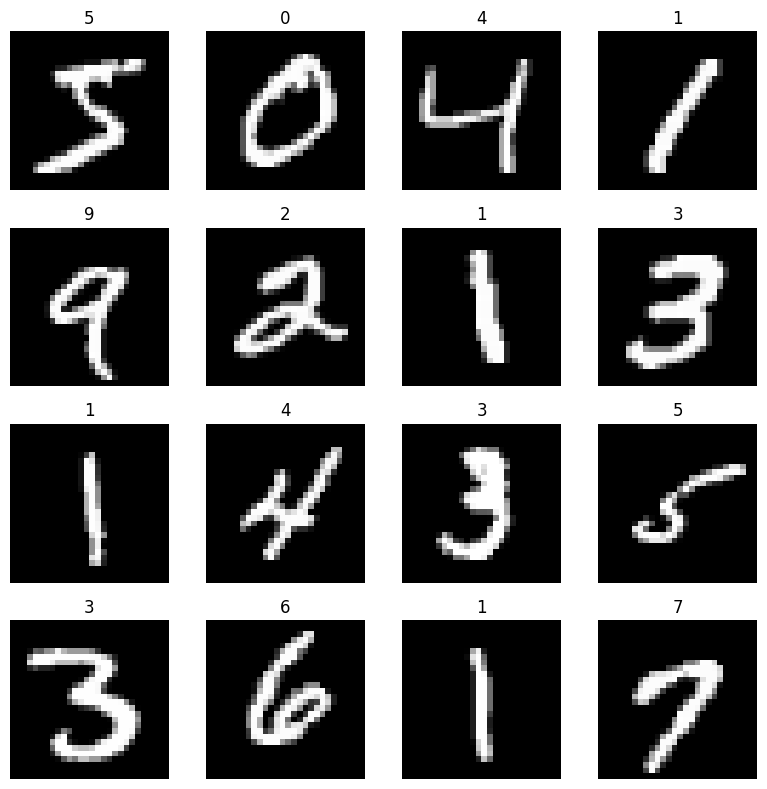

In [5]:
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(train_labels[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
train_images = train_images.reshape(-1, 784).astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(batch_size, drop_remainder=True)

#### ***数据目标优化***

<img src="./assets/优化目标.png" style="margin-left: 0px" width=800px>

#### ***模型的构造***

In [8]:
# 生成器模型
def build_generator(noise_dim):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(noise_dim,)),  # 输入层
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(img_shape, activation='sigmoid')
    ], name='generator')
    model.summary()
    return model

# 判别器模型
def build_discriminator(img_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(img_dim,)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ], name='discriminator')
    model.summary()
    return model

# GAN 模型初始化
generator = build_generator(noise_dim)
discriminator = build_discriminator(img_shape)

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 784)            │       101,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,064 (445.56 KB)

 Trainable params: 114,064 (445.56 KB)

 Non-trainable params: 0 (0.00 B)

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,609 (393.00 KB)

 Trainable params: 100,609 (393.00 KB)

 Non-trainable params: 0 (0.00 B)

这是一个最简单的GAN网络结构，后续可对模型进一步拓展，例如添加卷积层（生成高分辨率图像），或是改用函数式 API、使用 BatchNorm 层

#### ***构造目标函数（损失函数）***

In [9]:
# 损失函数和优化器
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# 判别器损失
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # 真实为1
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # 假为0
    return real_loss + fake_loss

# 生成器损失
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)  # 想骗过判别器

***Adam优化器*** 是一种 自适应学习率（adaptive learning rate）优化器，它能够 自动调节学习率，以更有效地优化模型的参数。

In [10]:
d_optimizer = tf.keras.optimizers.Adam(learning_rate)
g_optimizer = tf.keras.optimizers.Adam(learning_rate)

#### ***构造训练函数***

In [11]:
# 用于存储损失值
d_losses = []
g_losses = []

def train_step(real_images, epoch):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        d_loss = discriminator_loss(real_output, fake_output)
        g_loss = generator_loss(fake_output)

    gradients_of_generator = g_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = d_tape.gradient(d_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # 记录损失到数组
    d_losses.append(d_loss.numpy())  # 转换为普通数字并保存
    g_losses.append(g_loss.numpy())  # 转换为普通数字并保存

    return d_loss, g_loss


#### ***构造可视化函数***

可视化每轮epoch生成器生成的假图像

In [12]:
def generate_and_save_images(model, epoch, test_input):
    # 生成图像（关闭训练模式）
    predictions = model(test_input, training=False)

    # 创建图形
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i].numpy().reshape((28, 28)), cmap='gray')
        plt.axis('off')

    plt.suptitle(f'Epoch {epoch}')
    plt.show()  # 显示图像


可视化生成器和判别器的loss变化

In [13]:
def plot_gan_losses(d_losses, g_losses, steps_per_epoch):
    plt.figure(figsize=(12, 5))

    # 计算 epochs
    epochs = np.arange(len(d_losses)) / steps_per_epoch

    # 子图1：判别器损失
    plt.subplot(1, 2, 1)
    plt.plot(epochs, d_losses, color='red', label='Discriminator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Discriminator Loss')
    plt.grid(True)
    plt.legend()

    # 子图2：生成器损失
    plt.subplot(1, 2, 2)
    plt.plot(epochs, g_losses, color='blue', label='Generator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Generator Loss')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

#### ***主函数训练***

Epoch 35/100: 100%|██████████| 937/937 [00:27<00:00, 33.73it/s]


Epoch 35, D_loss: 0.4152, G_loss: 2.5940


Epoch 36/100: 100%|██████████| 937/937 [00:29<00:00, 31.55it/s]


Epoch 36, D_loss: 0.4109, G_loss: 2.2381


Epoch 37/100: 100%|██████████| 937/937 [00:29<00:00, 31.87it/s]


Epoch 37, D_loss: 0.4268, G_loss: 2.7508


Epoch 38/100: 100%|██████████| 937/937 [00:29<00:00, 31.60it/s]


Epoch 38, D_loss: 0.3688, G_loss: 2.5772


Epoch 39/100: 100%|██████████| 937/937 [00:29<00:00, 31.75it/s]


Epoch 39, D_loss: 0.5760, G_loss: 2.4047


Epoch 40/100: 100%|██████████| 937/937 [00:30<00:00, 31.06it/s]


Epoch 40, D_loss: 0.5386, G_loss: 2.2869


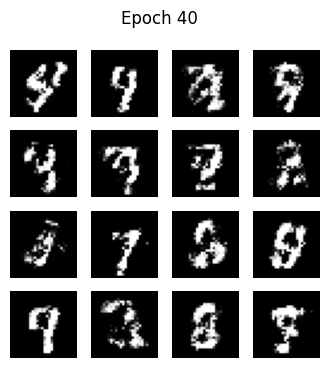

Epoch 41/100: 100%|██████████| 937/937 [00:33<00:00, 27.56it/s]


Epoch 41, D_loss: 0.4035, G_loss: 2.2261


Epoch 42/100: 100%|██████████| 937/937 [00:36<00:00, 25.35it/s]


Epoch 42, D_loss: 0.7231, G_loss: 2.4123


Epoch 43/100: 100%|██████████| 937/937 [00:30<00:00, 30.57it/s]


Epoch 43, D_loss: 0.3931, G_loss: 2.5726


Epoch 44/100: 100%|██████████| 937/937 [00:31<00:00, 30.21it/s]


Epoch 44, D_loss: 0.4562, G_loss: 2.7143


Epoch 45/100: 100%|██████████| 937/937 [00:29<00:00, 31.40it/s]


Epoch 45, D_loss: 0.3641, G_loss: 2.9481


Epoch 46/100: 100%|██████████| 937/937 [00:29<00:00, 31.96it/s]


Epoch 46, D_loss: 0.5786, G_loss: 2.5452


Epoch 47/100: 100%|██████████| 937/937 [00:29<00:00, 31.96it/s]


Epoch 47, D_loss: 0.4291, G_loss: 2.7442


Epoch 48/100: 100%|██████████| 937/937 [00:29<00:00, 32.00it/s]


Epoch 48, D_loss: 0.4612, G_loss: 2.7856


Epoch 49/100: 100%|██████████| 937/937 [00:28<00:00, 32.33it/s]


Epoch 49, D_loss: 0.4271, G_loss: 2.7191


Epoch 50/100: 100%|██████████| 937/937 [00:29<00:00, 31.42it/s]


Epoch 50, D_loss: 0.4335, G_loss: 2.6010


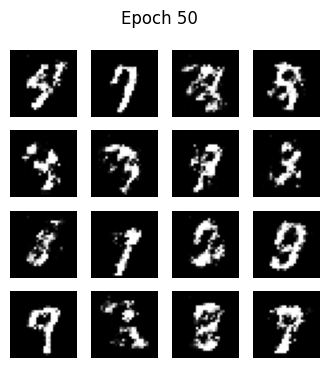

Epoch 51/100: 100%|██████████| 937/937 [00:29<00:00, 31.60it/s]


Epoch 51, D_loss: 0.4484, G_loss: 2.9381


Epoch 52/100: 100%|██████████| 937/937 [00:29<00:00, 32.28it/s]


Epoch 52, D_loss: 0.9250, G_loss: 1.7595


Epoch 53/100: 100%|██████████| 937/937 [00:29<00:00, 32.10it/s]


Epoch 53, D_loss: 0.5047, G_loss: 2.7551


Epoch 54/100: 100%|██████████| 937/937 [00:29<00:00, 32.12it/s]


Epoch 54, D_loss: 0.4255, G_loss: 3.0184


Epoch 55/100: 100%|██████████| 937/937 [00:28<00:00, 32.39it/s]


Epoch 55, D_loss: 0.3858, G_loss: 2.7758


Epoch 56/100: 100%|██████████| 937/937 [00:28<00:00, 32.34it/s]


Epoch 56, D_loss: 0.6368, G_loss: 2.7620


Epoch 57/100: 100%|██████████| 937/937 [00:28<00:00, 32.33it/s]


Epoch 57, D_loss: 0.6514, G_loss: 2.1467


Epoch 58/100: 100%|██████████| 937/937 [00:29<00:00, 32.17it/s]


Epoch 58, D_loss: 0.2920, G_loss: 3.5084


Epoch 59/100: 100%|██████████| 937/937 [00:29<00:00, 32.23it/s]


Epoch 59, D_loss: 0.5011, G_loss: 2.7712


Epoch 60/100: 100%|██████████| 937/937 [00:29<00:00, 32.02it/s]


Epoch 60, D_loss: 0.4647, G_loss: 2.2797


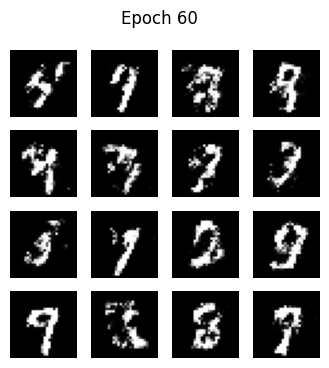

Epoch 61/100: 100%|██████████| 937/937 [00:29<00:00, 32.04it/s]


Epoch 61, D_loss: 0.5281, G_loss: 2.4907


Epoch 62/100: 100%|██████████| 937/937 [00:29<00:00, 32.25it/s]


Epoch 62, D_loss: 0.4687, G_loss: 2.6861


Epoch 63/100: 100%|██████████| 937/937 [00:29<00:00, 31.88it/s]


Epoch 63, D_loss: 0.7169, G_loss: 2.2605


Epoch 64/100: 100%|██████████| 937/937 [00:29<00:00, 32.16it/s]


Epoch 64, D_loss: 0.1864, G_loss: 3.2462


Epoch 65/100: 100%|██████████| 937/937 [00:29<00:00, 32.08it/s]


Epoch 65, D_loss: 1.7028, G_loss: 1.1606


Epoch 66/100: 100%|██████████| 937/937 [00:29<00:00, 31.90it/s]


Epoch 66, D_loss: 0.5595, G_loss: 2.6517


Epoch 67/100: 100%|██████████| 937/937 [00:29<00:00, 32.14it/s]


Epoch 67, D_loss: 0.4621, G_loss: 2.9998


Epoch 68/100: 100%|██████████| 937/937 [00:29<00:00, 32.24it/s]


Epoch 68, D_loss: 0.3766, G_loss: 2.9124


Epoch 69/100: 100%|██████████| 937/937 [00:29<00:00, 31.47it/s]


Epoch 69, D_loss: 1.1416, G_loss: 1.9816


Epoch 70/100: 100%|██████████| 937/937 [00:29<00:00, 31.47it/s]


Epoch 70, D_loss: 0.3692, G_loss: 2.9292


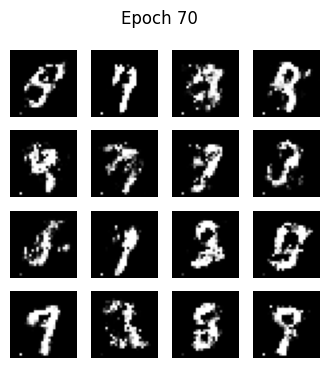

Epoch 71/100: 100%|██████████| 937/937 [00:29<00:00, 31.31it/s]


Epoch 71, D_loss: 0.5477, G_loss: 2.3327


Epoch 72/100: 100%|██████████| 937/937 [00:29<00:00, 32.10it/s]


Epoch 72, D_loss: 0.6636, G_loss: 2.3554


Epoch 73/100: 100%|██████████| 937/937 [00:29<00:00, 32.03it/s]


Epoch 73, D_loss: 0.4062, G_loss: 2.4791


Epoch 74/100: 100%|██████████| 937/937 [00:29<00:00, 32.04it/s]


Epoch 74, D_loss: 0.4822, G_loss: 3.0719


Epoch 75/100: 100%|██████████| 937/937 [00:29<00:00, 32.02it/s]


Epoch 75, D_loss: 0.4770, G_loss: 2.5336


Epoch 76/100: 100%|██████████| 937/937 [00:29<00:00, 32.13it/s]


Epoch 76, D_loss: 0.4896, G_loss: 2.2317


Epoch 77/100: 100%|██████████| 937/937 [00:29<00:00, 32.16it/s]


Epoch 77, D_loss: 0.7427, G_loss: 2.1311


Epoch 78/100: 100%|██████████| 937/937 [00:29<00:00, 32.12it/s]


Epoch 78, D_loss: 0.1748, G_loss: 3.9378


Epoch 79/100: 100%|██████████| 937/937 [00:29<00:00, 32.11it/s]


Epoch 79, D_loss: 0.5978, G_loss: 2.3913


Epoch 80/100: 100%|██████████| 937/937 [00:29<00:00, 32.18it/s]


Epoch 80, D_loss: 0.5109, G_loss: 2.2938


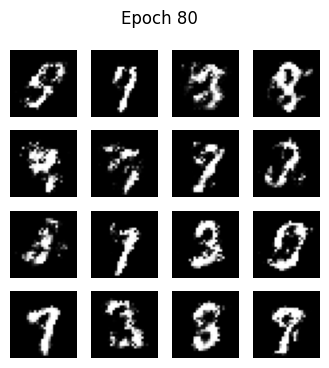

Epoch 81/100: 100%|██████████| 937/937 [00:30<00:00, 30.96it/s]


Epoch 81, D_loss: 0.5077, G_loss: 2.4246


Epoch 82/100: 100%|██████████| 937/937 [00:29<00:00, 32.01it/s]


Epoch 82, D_loss: 1.2755, G_loss: 1.7112


Epoch 83/100: 100%|██████████| 937/937 [00:30<00:00, 30.97it/s]


Epoch 83, D_loss: 0.4350, G_loss: 2.7034


Epoch 84/100: 100%|██████████| 937/937 [00:29<00:00, 31.59it/s]


Epoch 84, D_loss: 0.4874, G_loss: 2.8362


Epoch 85/100: 100%|██████████| 937/937 [00:29<00:00, 32.11it/s]


Epoch 85, D_loss: 0.4534, G_loss: 2.6898


Epoch 86/100: 100%|██████████| 937/937 [00:29<00:00, 31.90it/s]


Epoch 86, D_loss: 1.3922, G_loss: 1.4667


Epoch 87/100: 100%|██████████| 937/937 [00:28<00:00, 32.43it/s]


Epoch 87, D_loss: 0.8911, G_loss: 2.1306


Epoch 88/100: 100%|██████████| 937/937 [00:28<00:00, 32.74it/s]


Epoch 88, D_loss: 0.3968, G_loss: 3.0589


Epoch 89/100: 100%|██████████| 937/937 [00:28<00:00, 32.62it/s]


Epoch 89, D_loss: 1.2546, G_loss: 1.7434


Epoch 90/100: 100%|██████████| 937/937 [00:28<00:00, 32.33it/s]


Epoch 90, D_loss: 0.3116, G_loss: 3.2093


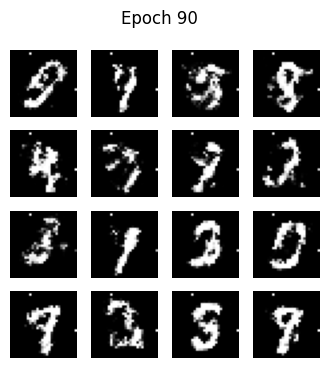

Epoch 91/100: 100%|██████████| 937/937 [00:30<00:00, 30.88it/s]


Epoch 91, D_loss: 0.7657, G_loss: 2.2160


Epoch 92/100: 100%|██████████| 937/937 [00:29<00:00, 31.30it/s]


Epoch 92, D_loss: 1.6035, G_loss: 1.4786


Epoch 93/100: 100%|██████████| 937/937 [00:29<00:00, 31.34it/s]


Epoch 93, D_loss: 0.9841, G_loss: 1.7926


Epoch 94/100: 100%|██████████| 937/937 [00:28<00:00, 32.43it/s]


Epoch 94, D_loss: 0.3477, G_loss: 2.8187


Epoch 95/100: 100%|██████████| 937/937 [00:28<00:00, 32.74it/s]


Epoch 95, D_loss: 0.6587, G_loss: 2.0813


Epoch 96/100: 100%|██████████| 937/937 [00:28<00:00, 32.56it/s]


Epoch 96, D_loss: 0.5263, G_loss: 2.1307


Epoch 97/100: 100%|██████████| 937/937 [00:28<00:00, 32.66it/s]


Epoch 97, D_loss: 0.8393, G_loss: 2.5390


Epoch 98/100: 100%|██████████| 937/937 [00:28<00:00, 32.76it/s]


Epoch 98, D_loss: 0.6049, G_loss: 2.1267


Epoch 99/100: 100%|██████████| 937/937 [00:29<00:00, 32.29it/s]


Epoch 99, D_loss: 0.6051, G_loss: 2.1518


Epoch 100/100: 100%|██████████| 937/937 [00:29<00:00, 31.42it/s]


Epoch 100, D_loss: 0.6846, G_loss: 1.8671


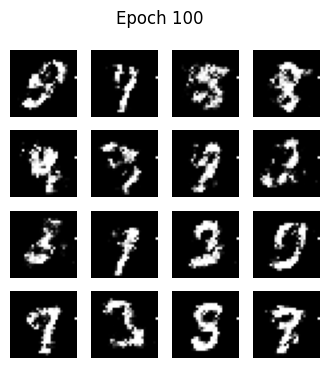

In [14]:
# 创建固定的测试输入（噪声）
seed = tf.random.normal([16, noise_dim])

# 主训练循环
for epoch in range(1, epochs + 1):
    for real_batch in tqdm(train_dataset,desc = f"Epoch {epoch}/{epochs}"):
        d_loss, g_loss = train_step(real_batch, epoch)

    print(f'Epoch {epoch}, D_loss: {d_loss:.4f}, G_loss: {g_loss:.4f}')

    if epoch % 10 == 0:
        generate_and_save_images(generator, epoch, seed)

In [15]:
import math

def get_steps_per_epoch(total_samples, batch_size):
    """计算每个epoch的训练步数"""
    return math.ceil(total_samples / batch_size)

steps_per_epoch = get_steps_per_epoch(train_samples, batch_size)
print(f"steps_per_epoch = {steps_per_epoch}")

steps_per_epoch = 938


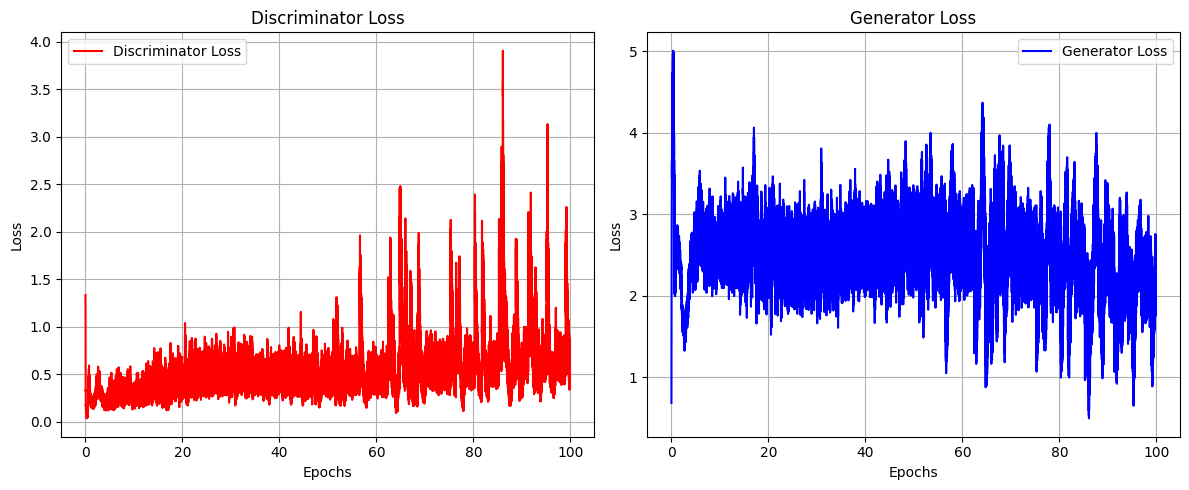

In [16]:
plot_gan_losses(d_losses, g_losses, steps_per_epoch)